In [353]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
# Set seaborn style
sns.set_style('whitegrid')

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

In [354]:
df = pd.read_csv("./data/reddit_comments_with_sentiment.csv", index_col=0)

In [355]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599 entries, 0 to 612
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              599 non-null    object
 1   sub_id            599 non-null    object
 2   title             599 non-null    object
 3   comment_id        599 non-null    object
 4   comment_author    596 non-null    object
 5   comment_text      599 non-null    object
 6   upvote_score      599 non-null    int64 
 7   comment_or_reply  599 non-null    object
 8   sentiment         599 non-null    object
dtypes: int64(1), object(8)
memory usage: 46.8+ KB


**Comments:**
- No Nulls are present except comment_author column. 
- This is fine as we would be primarily we would not be using this column.

### Column analysis

In [356]:
# Date column. change to datetime format.
df['date'] = pd.to_datetime(df['date'])
df.date.describe()

count                              599
mean     2023-04-25 15:35:12.480801280
min                2023-04-22 23:44:49
25%                2023-04-24 16:34:43
50%                2023-04-26 05:11:22
75%                2023-04-26 05:11:22
max                2023-04-26 14:22:27
Name: date, dtype: object

**Observation**
- Earliest date of the post is 22 Apr to 26 Apr when this topic was hot.

In [357]:
df['title'].value_counts()

title
Breaking: Singapore will execute man tomorrow over possession of Cannabis. So tragic, light one up for man if you’re fortunate to be able to                           269
Tangaraju Suppiah executed after family's appeals for mercy failed - Singapore News                                                                                    100
46-year-old Singaporean Tangaraju Suppiah is Set to Hang on 26th April for Cannabis Trafficking - Is Death too Harsh a Punishment?                                      78
Why Tangaraju Suppiah doesn’t deserve to die                                                                                                                            37
Foreigner Richard Branson Pokes His Nose in Singapore's Laws                                                                                                            36
Even those who agree with the death penalty should worry about Tangaraju Suppiah's looming execution: Activist - Singapore News            

**Observation** </br>
- Extracted post titles are relevant.

In [358]:
#check 'upvote_score'
df['upvote_score'].describe()

count     599.000000
mean       26.627713
std       170.818529
min      -186.000000
25%         1.000000
50%         2.000000
75%        10.000000
max      3329.000000
Name: upvote_score, dtype: float64

**Observations**
-  Some comments have been downvoted indicated by the negative score. 
- Maximum number of upvotes is about 3K
- median is about 2 upvotes indicated a large number of comments had a very small number of upvotes

In [359]:
df['comment_or_reply'].value_counts()

comment_or_reply
comment    371
reply      228
Name: count, dtype: int64

**Comments**
- We have a mixed number of comments or replies to comments in the data

Text(0, 0.5, 'Number of words')

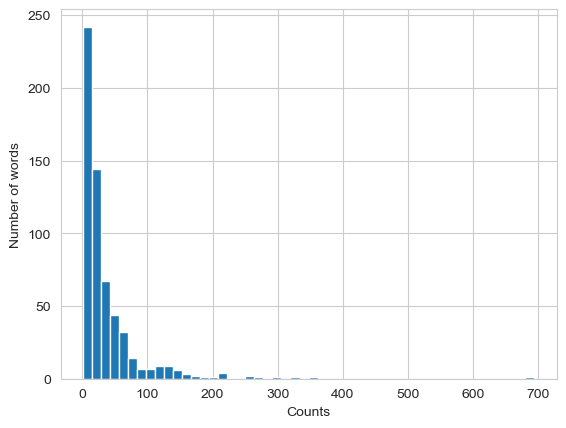

In [360]:
df['comment_length'] = df['comment_text'].str.split().apply(len)
df['comment_length'].hist(bins=50)
plt.xlabel('Counts')
plt.ylabel('Number of words')

**Observations**
- No of words in a comment is plotted in the histogram above.
- We can observe that higher frequency of comments has fewer words in the comments.

In [361]:
df['comment_length'].describe()

count    599.000000
mean      35.632721
std       52.913149
min        1.000000
25%        9.000000
50%       18.000000
75%       41.000000
max      694.000000
Name: comment_length, dtype: float64

**Comments**
- Median word length of the comments including stop words is about 20 words. There are some long comments.


In [362]:
df.sort_values(by='comment_length', ascending=False)[['comment_text']].head()

,comment_text
338,"It's not that easy to get caught and charged with trafficking drugs and get you the mandatory death penalty, as long as you're not in the illegal drug trade.\n\n1. Don't succumb to temptation and traffic drugs, however desperate you are for cash.\n\n2. Mix with the right company. Don't get addicted to drugs and if you already are, go for rehab before the drugs mess with your mind so much you p..."
182,I believe the more important factor/question isn't about the legality of cannabis in sg but rather the fact that he tried to traffick/smuggle it. (I'm for death penalty)\n\nConsuming it in Singapore is one thing - trying to bring it into Singapore is another. As for death penalty - I'm pretty sure its only the traffickers who gets it (might be wrong). If you consume drugs (be it 'hard' like co...
59,"Easy to say just don’t do drugs, stopping an addiction to such substances is way more complex than what people here would like to believe. Desistance is not just about stopping the acts of drug taking, but also about believing in yourself adopting a new identity from before (you are no longer an addict and therefore will not partake in such an activity any further) \n\nIt’s not as simple as we..."
10,"The argument is that the mandatory death penalty is ineffectual because you tend to wind up executing large numbers of mules who basically don't impact the drug trade. Occasionally getting some mid level facilitator like this guy does not change the overall picture. TBH, I never really agreed with this argument because I think that the death penalty should perhaps only be used in the case of p..."
319,"I personally don't agree with legalisation, but perhaps decriminalisation for soft drugs, especially ones that have proven medicinal benefits, such as cannabis or psilocybin might be a smart move. \n\nSome drugs are legal in a growing number of places now, but it is often because drug use and addiction is so widespread in society, that it is simply no longer possible to police its use, so auth..."


**Observations**
- Top comments with the bigger word count is shown above. Few people write longer comments forming complex logical arguments.

In [363]:
df.sort_values(by='comment_length', ascending=True)[['comment_text']].head()

,comment_text
93,yes
564,😢😢😢
359,Respect.
526,Martyr
435,Barbaric


**Observations**
- Long comments are analysis presented by users. Short commetns are emotions.

<Axes: xlabel='comment_length', ylabel='Probability'>

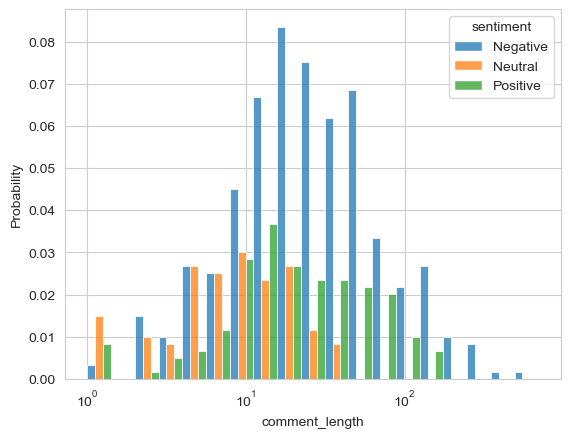

In [364]:
sns.histplot(df, x= 'comment_length', hue='sentiment', log_scale=True, stat='probability', multiple='dodge')

**Observations**
- Negative sentiment sentences have a longer length. While neutral have the shortest

<Axes: ylabel='sentiment'>

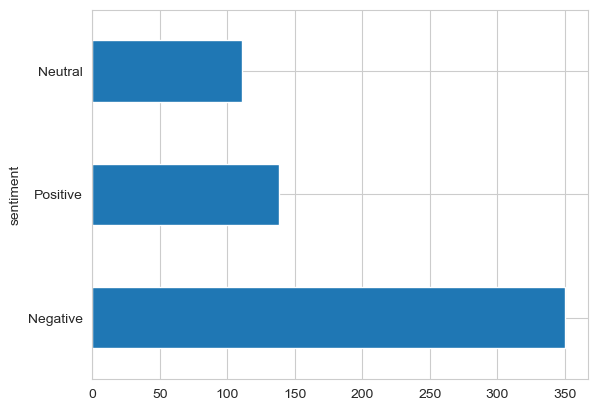

In [365]:
df.sentiment.value_counts().plot(kind='barh')

**Observations**
- A large number of negative sentiments

### Pre-processing

In [366]:
# Convert all to lower string
df['comment_text_lower'] = df['comment_text'].str.lower()

In [367]:
tokenizer = RegexpTokenizer(r'\w+') 
df['comment_text_tokenized']  =  df['comment_text_lower'].apply(lambda x: tokenizer.tokenize(x))

In [368]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()
df['comment_text_lemmatized'] = df['comment_text_tokenized'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [369]:
df['comment_text_swremoved'] = df['comment_text_lemmatized'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])


In [370]:
# Instantiate PorterStemmer.
p_stemmer = LancasterStemmer()
df['comment_text_stemmed'] = df['comment_text_swremoved'].apply(lambda x: [p_stemmer.stem(i) for i in x])

In [371]:
df['comments_final'] = df['comment_text_stemmed'].apply(lambda x: ' '.join(x))

### Modelling

In [372]:
df.columns

Index(['date', 'sub_id', 'title', 'comment_id', 'comment_author',
       'comment_text', 'upvote_score', 'comment_or_reply', 'sentiment',
       'comment_length', 'comment_text_lower', 'comment_text_tokenized',
       'comment_text_lemmatized', 'comment_text_swremoved',
       'comment_text_stemmed', 'comments_final'],
      dtype='object')

In [373]:
#train test splits. Use stratify since it is a unbalanced y
X = df['comments_final'].copy()
y = df['sentiment'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle = True, stratify=y)


### Naive Bayes (BN)

In [374]:
# NB
pipe = Pipeline([
    ('vec',  TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters
pipe_params = {
    'vec__max_features': [100, 200, 500, 1000],
    'vec__ngram_range': [(1,1), (1,2), (1,3)],
    'nb__alpha': np.linspace(1, 10, 10)*1e-3
}

In [521]:
# Instantiate GridSearchCV
gs_nb = GridSearchCV(pipe, pipe_params, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc_ovr_weighted')

# Fit GridSearch to training data
gs_nb.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs_nb.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


{'rf__max_depth': 100,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 100,
 'vec__max_features': 500,
 'vec__ngram_range': (1, 2)}

In [522]:
gs_nb.best_score_

0.7815803343376816

In [523]:
print(f" train score  {gs_nb.best_estimator_.score(X_train, y_train)}")
print(f" test score {gs_nb.best_estimator_.score(X_test, y_test)}")

 train score 0.955456570155902
 test score 0.5733333333333334


**Observations:**
- Higher train score due to the model is already trained on the X_train. Therefore, it is showing higher values as expected.
- Test score shows lower values compared to the best fit model

### RandomForest

In [528]:
# RandomForest
pipe = Pipeline([
    ('vec',  TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

# Search over the following values of hyperparameters
pipe_params = {
    'vec__max_features': [200, 500],
    'vec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [25, 50],
    'rf__max_depth': [ 25, 50],
    'rf__min_samples_split': [10, 15, 25]
}

In [529]:
# Instantiate GridSearchCV
gs_rf = GridSearchCV(pipe, pipe_params, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc_ovr_weighted')

# Fit GridSearch to training data
gs_rf.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs_rf.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'rf__max_depth': 50,
 'rf__min_samples_split': 25,
 'rf__n_estimators': 50,
 'vec__max_features': 500,
 'vec__ngram_range': (1, 2)}

In [530]:
gs_rf.best_score_


0.7739341449481034

In [531]:
print(f" train score {gs_rf.best_estimator_.score(X_train, y_train)}")
print(f" test score {gs_rf.best_estimator_.score(X_test, y_test)}")

 train score 0.9131403118040089
 test score 0.58


**Observations:**
- Higher train score due to the model is already trained on the X_train. Therefore, it is showing higher values as expected.
- Test score shows lower values compared to the best fit model

### KNN

In [485]:
# KNN
pipe = Pipeline([
    ('vec',  TfidfVectorizer()),
    ('kn', KNeighborsClassifier())
])

# Search over the following values of hyperparameters
pipe_params = {
    'vec__max_features': [200, 5000],
    'vec__ngram_range': [(1,1), (1,2), (1,3)],
    'kn__n_neighbors': [10, 20, 30] 
}

In [506]:
# Instantiate GridSearchCV
gs_kn = GridSearchCV(pipe, pipe_params, cv=5, verbose=True, n_jobs=-1, scoring='roc_auc_ovr_weighted')

# Fit GridSearch to training data
gs_kn.fit(X_train, y_train)

# Finding the Best Hyperparameter Values
gs_kn.best_params_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


{'rf__max_depth': 100,
 'rf__min_samples_split': 15,
 'rf__n_estimators': 50,
 'vec__max_features': 1000,
 'vec__ngram_range': (1, 2)}

In [507]:
gs_kn.best_score_

0.7818897754463192

In [532]:
print(f" train score {gs_kn.best_estimator_.score(X_train, y_train)}")
print(f" test score {gs_kn.best_estimator_.score(X_test, y_test)}")

 train score 0.9732739420935412
 test score 0.6133333333333333


**Observations:**
- Higher train score due to the model is already trained on the X_train. Therefore, it is showing higher values as expected.
- Test score shows lower values compared to the best fit model

In [533]:
y_pred = gs_rf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.62      0.88      0.72        88
     Neutral       0.33      0.14      0.20        28
    Positive       0.46      0.18      0.26        34

    accuracy                           0.58       150
   macro avg       0.47      0.40      0.39       150
weighted avg       0.53      0.58      0.52       150



In [452]:

cr =classification_report(y_test, y_pred, output_dict=True )
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
Negative,0.602941,0.931818,0.732143,88.000000
Neutral,0.250000,0.035714,0.062500,28.000000
Positive,0.600000,0.176471,0.272727,34.000000
accuracy,0.593333,0.593333,0.593333,0.593333
macro avg,0.484314,0.381334,0.355790,150.000000
weighted avg,0.536392,0.593333,0.503009,150.000000


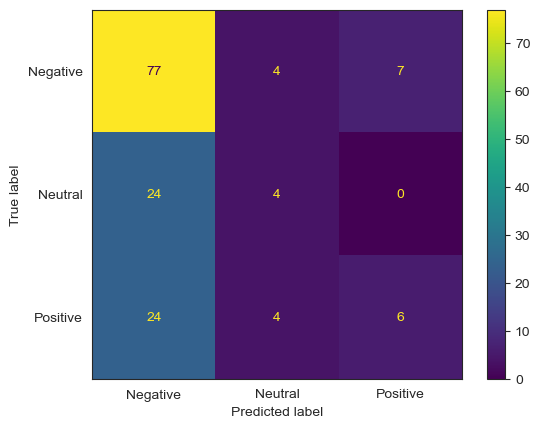

In [534]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)